# Demo:  Gradient Descent Optimization

In the [breast cancer demo](../logistic/breast_cancer.ipynb), we used the `sklearn` built-in `LogisticRegression` class to find the weights for the logistic regression problem.   The `fit` routine in that class has an *optimizer* to select the weights to best match the data.  To understand how that optimizer works, in this demo, we will build a very simple gradient descent optimizer from scratch.  You will learn to:
* Compute the gradients of a simple loss function and implement the gradient calculations in python
* Implement a simple gradient descent optimizer
* Visualize the effect of the learning rate in gradient descent
* Implement an adaptive learning rate algorithm

## Loading the Breast Cancer Data

We first load the standard packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn import preprocessing

We next load the data from the [breast cancer demo](../logistic/breast_cancer.ipynb).  

In [2]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df.head()

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


As in the breast cancer demo, we create a data matrix `X` of various features of the breast cancer sample.  The response vector `y` is a binary indicating if each sample is benign or malignant.  

In [3]:
# Get the predictors
xnames = names[1:-1]
X = np.array(df[xnames])

# Get the response.  Convert to a zero-one indicator 
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int)

We want to learn the classification rule to predict `y` from `X`.  To this end, we first split the data into training and test and then scale.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into training and test
Xtr, Xts, ytr, yts = train_test_split(X,y, test_size=0.30)

# Scale data
scal = StandardScaler()
Xtr1 = scal.fit_transform(Xtr)
Xts1 = scal.transform(Xts)

Just as a reference, let's see the test accuracy on this split using sklearn's built-in optimizer.

In [5]:
# Fit the model
from sklearn import linear_model
reg = linear_model.LogisticRegression(C=1e5)
reg.fit(Xtr1, ytr)

# Measure the test error
yhat = reg.predict(Xts1)
acc = np.mean(yhat == yts)
print("Accuracy on test data = %f" % acc)

Accuracy on test data = 0.970732


## Computing the Gradient and Loss Function

Recall that training a logistic function means finding a weight vector `w` for the classification rule:

    P(y=1|x,w) = 1/(1+\exp(-z)), z = w[0] + w[1]*x[0] + ... + w[k]x[k-1]
    
From the class notes in logistic regression, we saw that the weight vector can be found by minimizing  the negative log likelihood.  The negative log likelihood is called the *loss* function.  For the logistic regression problem, the loss function simplifies to:


    f(w) = \sum_i -y[i]z[i] + ln(1+exp(z[i])),  z[i] = w[0] + w[1]X[i,0] + ... + w[k]X[i,k-1].
    
We first write a function to compute `f` and its gradient `feval`.

In [6]:
def feval(w,X,y):
    """
    Compute the loss and gradient given w,X,y
    """
    # Construct transform matrix
    n = X.shape[0]
    A = np.column_stack((np.ones(n,), X))

    # The loss is the binary cross entropy
    z = A.dot(w)
    py = 1/(1+np.exp(-z))
    f = np.sum((1-y)*z - np.log(py))

    # Gradient
    df_dz = py-y
    fgrad = A.T.dot(df_dz)
    return f, fgrad

One issue is that the function `f(w,X,y)` depends on the parameters `X` and `y`.  Most numerical optimizers expect a function that only depends on `w`.  So, we need an alternate way to pass those parameters to the function.  There are two approaches.

### Method 1.  Use a class method

One approach to pass the parameters is to implement the function as a method in a class that contains the parameters.  In the code below, we create a class `LogisticFun` where the constructor takes the parameters `X` and `y`.  Then, the class method `feval` takes a variable `w` and computes the loss and its gradient.  

You can see that one benefit of using a class method is that processing that is independent of `w` can be performed in the contructor.  For example, in the code below, constructs `self.A` in the constructor.  Then this step does not need to be repeated every time the function is called.

In [7]:
class LogisticFun(object):
    def __init__(self,X,y):
        """
        Class to computes the loss and gradient for a logistic regression problem.
        
        The constructor takes the data matrix `X` and response vector y for training.
        """
        self.X = X
        self.y = y
        n = X.shape[0]
        self.A = np.column_stack((np.ones(n,), X))

    def feval(self,w):
        """
        Compute the loss and gradient for a given weight vector
        """
        # The loss is the binary cross entropy
        z = self.A.dot(w)
        py = 1/(1+np.exp(-z))
        f = np.sum((1-self.y)*z - np.log(py))
        
        # Gradient
        df_dz = py-self.y
        fgrad = self.A.T.dot(df_dz)
        return f, fgrad

Once we have defined the class we can create an *instance* of the class with the training data.

In [8]:
log_fun = LogisticFun(Xtr1,ytr)

Then, we can call the method with only the value `w`.

In [9]:
# Some random point
p = X.shape[1]+1
w0 = np.random.randn(p)

# Call the function
f, fgrad = log_fun.feval(w0)

### Method 2.  Using Lambda functions

An alternative method is to use python `lambda` functions.  The code below creates uses the `lambda` construction to fix the parameters `X` and `y`.  A slight disadvantage of this method is that the pre-processing is less easy to separate.

In [10]:
# Create a function with X,y fixed
feval_param = lambda w: feval(w,Xtr1,ytr)

# You can now pass a parameter like w0
f0, fgrad0 = feval_param(w0)

### Testing the gradient

Either way you create the function, it is very important to test if the gradient is correct.  This is the number one reason people's code does not work with numerical optimizers.  The simplest method is to take two points `w0` and `w1` that are close to one another and then verify that 

    f(w1) - f(w0) \approx fgrad(w0).dot(w1 - w0)

In [11]:
# Take a random initial point
p = X.shape[1]+1
w0 = np.random.randn(p)

# Perturb the point
step = 1e-6
w1 = w0 + step*np.random.randn(p)

# Measure the function and gradient at w0 and w1
f0, fgrad0 = log_fun.feval(w0)
f1, fgrad1 = log_fun.feval(w1)

# Predict the amount the function should have changed based on the gradient
df_est = fgrad0.dot(w1-w0)

# Print the two values to see if they are close
print("Actual f1-f0    = %12.4e" % (f1-f0))
print("Predicted f1-f0 = %12.4e" % df_est)

Actual f1-f0    =   6.3669e-05
Predicted f1-f0 =   6.3669e-05


You can see that the two agree well.  You would have got the same answer had you used the `feval` constructed in method 2.

## A Simple Gradient Descent Optimizer

Now, we build a "barebones" gradient descent optimizer function with a fixed learning rate.

In [12]:
def grad_opt_sim(feval, winit, lr=1e-3,nit=1000):
    """
    Simple gradient descent optimization
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    lr:     learning rate
    nit:    Number of iterations
    """
    # Initialize
    w0 = winit
  
    # Loop over iterations
    for it in range(nit):

        # Evaluate the function and gradient
        f0, fgrad0 = feval(w0)

        # Take a gradient step
        w0 = w0 - lr*fgrad0

    return w0, f0

The above code will work, but to get a bit more insight, we can modify this code to add a history dictionary that keeps track of the loss function and values over iteration.

In [13]:
def grad_opt_simp(feval, winit, lr=1e-3,nit=1000):
    """
    Simple gradient descent optimization
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    lr:     learning rate
    nit:    Number of iterations
    """
    # Initialize
    w0 = winit
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'w': [], 'f': []}
    
    # Loop over iterations
    for it in range(nit):

        # Evaluate the function and gradient
        f0, fgrad0 = feval(w0)

        # Take a gradient step
        w0 = w0 - lr*fgrad0
        
         # Save history
        hist['f'].append(f0)
        hist['w'].append(w0)

    # Convert to numpy arrays
    for elem in ('f', 'w'):
        hist[elem] = np.array(hist[elem])
    return w0, f0, hist

We now run the gradient descent starting from a random initial condition.

Text(0, 0.5, 'Training loss')

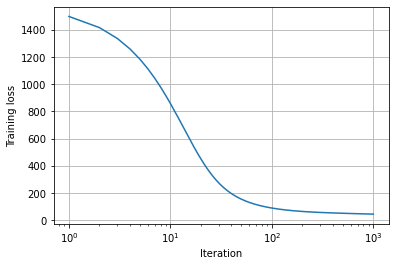

In [14]:
# Initial condition
winit = np.random.randn(p)

# Parameters
feval = log_fun.feval
nit = 1000
lr = 1e-4

# Run the gradient descent
w, f0, hist = grad_opt_simp(feval, winit, lr=lr, nit=nit)

# Plot the training loss
t = np.arange(nit)+1
plt.semilogx(t, hist['f'])
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss')

We can measure the accuracy of the final estimate by creating a predict method.

In [15]:
def predict(X,w):
    z = X.dot(w[1:]) + w[0]
    yhat = (z > 0)
    return yhat

yhat = predict(Xts1,w)
acc = np.mean(yhat == yts)
print("Test accuracy = %f" % acc)

Test accuracy = 0.965854


You will likely not get a test accuracy quite as good as the test accuracy for the `sklearn` method, although there is some variation with the train-test split.  The reason is that the learning rate was somewhat slow and we didn't yet fully converge.

To see the effect of the learning rate, the code below tries different learning rates.

lr=    1.00e-05  Test accuracy = 0.946341
lr=    1.00e-04  Test accuracy = 0.965854
lr=    1.00e-03  Test accuracy = 0.970732


Text(0, 0.5, 'Training loss')

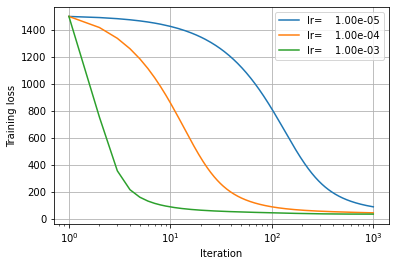

In [16]:
# Learning rate values to test
lr_test = [1e-5,1e-4,1e-3]
ntest = len(lr_test)

# Strings for the legend
leg_str = []
losshist = []

for i, lr in enumerate(lr_test):
    # Run the optimizer
    w, f0, hist = grad_opt_simp(feval, winit, lr=lr, nit=nit)    
    losshist.append(hist['f'])
    
    # Plot the results
    t = np.arange(nit)+1
    plt.semilogx(t, hist['f'])
    leg_str.append("lr=%12.2e" % lr)
    
    # Measure the test accuracy
    yhat = predict(Xts1,w)
    acc = np.mean(yhat == yts)
    print("lr=%12.2e  Test accuracy = %f" % (lr, acc))
    
plt.grid()
plt.legend(leg_str, loc='upper right')
plt.xlabel('Iteration')
plt.ylabel('Training loss')

You can see that increase the learning rate more to speed up the convergence time.  Again, although it depends on the train-test split, generally you will also get higher test accuracy with the faster learning rate.  But, you cannot increase the learning rate too high as the optimization may go unstable.

## Adaptive Step Size

The above example shows that gradient descent is sensitive to the step size.  We now consider a slight variant of gradient descent with an adaptive step-size using the Armijo rule in class.

In [17]:
def grad_opt_adapt(feval, winit, nit=1000, lr_init=1e-3, lr_min=1e-6):
    """
    Gradient descent optimization with adaptive step size
    
    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    winit:  Initial estimate
    nit:    Number of iterations
    lr_init:     Initial learning rate
    lr_min:      Minimum learning rate
    """
    
    # Set initial point
    w0 = winit
    f0, fgrad0 = feval(w0)
    print(fgrad0)
    lr = lr_init
    
    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it 
    # is useful for debugging
    hist = {'lr': [], 'w': [], 'f': []}

    for it in range(nit):

        # Take a gradient step
        w1 = w0 - lr*fgrad0

        # Evaluate the test point by computing the objective function, f1,
        # at the test point and the predicted decrease, df_est
        f1, fgrad1 = feval(w1)
        df_est = fgrad0.dot(w1-w0)
        
        # Check if test point passes the Armijo condition
        alpha = 0.5
        if (f1-f0 < alpha*df_est) and (f1 < f0):
            # If descent is sufficient, accept the point and increase the
            # learning rate
            lr = lr*2
            f0 = f1
            fgrad0 = fgrad1
            w0 = w1
        else:
            # Otherwise, decrease the learning rate
            lr = lr/2
            lr = np.maximum(lr, lr_min)
            
        # Save history
        hist['f'].append(f0)
        hist['lr'].append(lr)
        hist['w'].append(w0)

    # Convert to numpy arrays
    for elem in ('f', 'lr', 'w'):
        hist[elem] = np.array(hist[elem])
    return w0, f0, hist


We can now run the new optimizer.

[ 107.15782989  -72.6155476  -114.08688876 -119.03256223  -79.24441787
 -113.86672363  -91.52543696  -68.23957223 -112.10101875  -82.29373004]


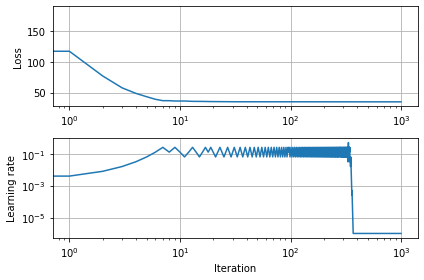

In [18]:
winit = np.random.randn(p)
nit = 1000
w, f0, hist = grad_opt_adapt(feval, winit, nit=nit)

t = np.arange(nit)
plt.subplot(2,1,1)
plt.semilogx(t, hist['f'])
plt.grid()
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.loglog(t, hist['lr'])
plt.grid()
plt.ylabel('Learning rate')
plt.xlabel('Iteration')

plt.tight_layout()

Finally we measure the accuracy.

In [19]:
yhat = predict(Xts1,w)
acc = np.mean(yhat == yts)
print("Test accuracy = %f" % acc)

Test accuracy = 0.970732


## In-Class Exercise

Try to a build a simple optimizer to minimize:

    f(w) = a[0] + a[1]*w + a[2]*w^2 + ... + a[d]*w^d
    
for the coefficients `a = [0,0.5,-2,0,1]`.

* Plot the function f(w)
* Can you see where the minima is?
* Write a function that outputs f(w) and its gradient.
* Run the optimizer on the function to see if it finds the minima.
* Print the funciton value and number of iterations.
* Bonus:  Instead of writing the function for a specific coefficient vector `a`, create a class that works for an arbitrary vector `a`.

You may wish to use the `poly.polyval(w,a)` method to evaluate the polynomial.

In [20]:
import numpy.polynomial.polynomial as poly


